<a href="https://colab.research.google.com/github/rnklee/ultrasound-nerve-segmentation/blob/main/nerve_segmentation_practice_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip install torcheval
! pip install scikit-image
! pip install ipympl

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-08s3tb_e
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-08s3tb_e
  Resolved https://github.com/albu/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


In [83]:
import sys, os
import re
import time
import pickle

In [84]:
from tqdm import tqdm

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from skimage.metrics import structural_similarity as ssim

from PIL import Image
import cv2

import random, itertools

from collections import OrderedDict
from functools import partial

import pdb

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

from torch.utils.data import Dataset, DataLoader, sampler

import torchvision
from torchvision import transforms, models

import segmentation_models_pytorch as smp
import albumentations

import segmentation_models_pytorch.utils.metrics
import segmentation_models_pytorch.utils.losses

# Load data from GitHub

In [87]:
!git clone https://github.com/rnklee/ultrasound-nerve-segmentation

Cloning into 'ultrasound-nerve-segmentation'...
remote: Enumerating objects: 8023, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 8023 (delta 24), reused 9 (delta 9), pack-reused 7986
Receiving objects: 100% (8023/8023), 1.55 GiB | 22.80 MiB/s, done.
Resolving deltas: 100% (209/209), done.
Updating files: 100% (11299/11299), done.


In [88]:
%cd ultrasound-nerve-segmentation

/content/ultrasound-nerve-segmentation/ultrasound-nerve-segmentation


In [89]:
ultrasoundpath = '.'
trainpath = './train/'
datapath = './data/'
modelspath = './models/'

In [90]:
with open(datapath + '/cleaned_masks.pkl', 'rb') as f:
    masks = pickle.load(f)
with open(datapath + '/cleaned_images.pkl', 'rb') as f:
    images = pickle.load(f)
with open(datapath + '/cleaned_strat.pkl', 'rb') as f:
    stratify = pickle.load(f)

In [91]:
masks = [o.replace('/content/drive/MyDrive/ultrasound-nerve-segmentation/train', '') for o in masks]
images = [o.replace('/content/drive/MyDrive/ultrasound-nerve-segmentation/train', '') for o in images]

In [92]:
with open(datapath + '/train_test_msks.pkl', 'rb') as f:
    train_test_msks = pickle.load(f)
with open(datapath + '/train_test_stratify.pkl', 'rb') as f:
    train_test_stratify = pickle.load(f)
with open(datapath + '/test_msks.pkl', 'rb') as f:
    test_msks = pickle.load(f)
with open(datapath + '/train_msks.pkl', 'rb') as f:
    train_msks = pickle.load(f)
with open(datapath + '/valid_msks.pkl', 'rb') as f:
    valid_msks = pickle.load(f)

In [93]:
# !git config --global user.email "rnklee@terpmail.umd.edu"
# !git config --global user.name "Rachel"
# !git add --all
# !git commit -m
# !git push 'https://MY_TOKEN@github.com/rnklee/ultrasound-nerve-segmentation.git'

# Necessary definitions

In [94]:
class NerveDataset(Dataset):
    def __init__(self, mskfiles, color=True, preprocess=None, augment=None, train=True):
        super().__init__()

        self.mskfiles = [trainpath+o for o in mskfiles]
        self.imgfiles = [o.replace('_mask', '') for o in self.mskfiles]

        self.preprocess = preprocess
        self.augment = augment
        self.color = color


    def __len__(self):
        return len(self.mskfiles)


    def __getitem__(self, idx):
        if self.color:
            img = cv2.imread(self.imgfiles[idx])
        else:
            img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment is not None:
            sample = self.augment(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if self.preprocess is not None:
            sample = self.preprocess(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if not self.color:
            img = np.expand_dims(img, axis=0)
        img = img.astype(np.float32)
        msk = (msk/255).astype(np.float32)
        msk = np.expand_dims(msk, axis=0)

        return img, msk

In [95]:
def has_nerve(mask):
    o = cv2.imread(trainpath+mask, cv2.IMREAD_GRAYSCALE)
    return 1 if o.any() else 0

In [96]:
def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')

### Simpler ResNet-UNet
ResNet encoder implementation adopted from https://github.com/FrancescoSaverioZuppichini/ResNet. Decoder implementation adopted from [smp implementaion of UNet](https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch/decoders/unet).

In [97]:
class Conv2dAuto(nn.Conv2d):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.padding = (self.kernel_size[0]//2, self.kernel_size[1]//2)


def conv_bn(inplanes, planes, kernel_size=3, stride=1, *args, **kwargs):
    conv = partial(Conv2dAuto, kernel_size=kernel_size, stride=stride, bias=False)
    return nn.Sequential(OrderedDict(
        {
            'conv' : conv(inplanes, planes, *args, **kwargs),
            'bn' : nn.BatchNorm2d(planes)
        }
    ))


conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [98]:
class ResNetBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, expansion=1, downsampling=1, *args, **kwargs):
        super().__init__()
        self.inplanes, self.planes = inplanes, planes
        self.expansion, self.downsampling = expansion, downsampling

        self.blocks = nn.Identity()
        self.shortcut = nn.Sequential(OrderedDict(
            {
                'conv_bn' : conv_bn(self.inplanes, self.expansion * self.planes, kernel_size=1, stride=self.downsampling)
            }
        )) if self.inplanes != self.expansion * self.planes else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x



class ResNetBasicBlock(ResNetBlock):
    def __init__(self, inplanes, planes, kernel_size=3, activation=nn.ReLU, *args, **kwargs):
        super().__init__(inplanes, planes, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.inplanes, self.planes, kernel_size=kernel_size, stride=self.downsampling),
            activation(),
            conv_bn(self.planes, self.expansion * self.planes, kernel_size=kernel_size)
        )



class ResNetBottleneckBlock(ResNetBlock):
    expansion = 4
    def __init__(self, inplanes, planes, kernel_size=3, activation=nn.ReLU, *args, **kwargs):
        super().__init__(inplanes, planes, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.inplanes, self.planes, kernel_size=1),
            activation(),
            conv_bn(self.planes, self.planes, kernel_size=kernel_size, stride=self.downsampling),
            activation(),
            conv_bn(self.planes, self.expansion * self.planes, kernel_size=1)
        )



class ResNetLayer(nn.Module):
    def __init__(self, inplanes, planes, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        self.downsampling = 2 if inplanes != planes else 1

        self.blocks = nn.Sequential(
            block(inplanes, planes, *args, **kwargs, downsampling=self.downsampling),
            *[block(block.expansion * planes, block.expansion * planes, downsamplig=1, *args, **kwargs) for _ in range(n-1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x



class ResNetEncoder(nn.Module):
    # no stem if stem_size=0
    def __init__(self, inplanes=3, stem_size=64, block_sizes=[64,128,256,512], depths=[2,2,2,2],
                 activation=nn.ReLU, block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.out_channels = [stem_size] + block_sizes if stem_size else block_sizes

        if stem_size:
            self.stem = nn.Sequential(
                conv_bn(inplanes, stem_size, kernel_size=7, stride=2),
                activation(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
            inplanes = stem_size

        else:
            self.stem = nn.Identity()

        in_out_planes = list(zip(block_sizes[:-1], block_sizes[1:]))
        self.layers = nn.ModuleList([
            ResNetLayer(inplanes, block_sizes[0], n=depths[0], activation=activation, block=block, *args, **kwargs),
            *[ResNetLayer(inplanes*block.expansion, planes, n=n, activation=activation, block=block, *args, **kwargs)
            for (inplanes, planes), n in zip(in_out_planes, depths[1:])]
        ])

        downsampling = [layer.downsampling for layer in self.layers]
        self.downsampling = [4] + downsampling if stem_size else downsampling


    def forward(self, x):
        x = self.stem(x)
        outputs = [x]
        for layer in self.layers:
            x = layer(x)
            outputs = [x] + outputs
        return outputs

In [99]:
# UNet implementation adopted from smp source code.
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, skip_channel, out_channel):
        super().__init__()
        self.in_channel, self.skip_channel, self.out_channel = in_channel, skip_channel, out_channel
        self.blocks = nn.Sequential(
            conv_bn(in_channel + skip_channel, out_channel),
            conv_bn(out_channel, out_channel)
        )

    def forward(self, x, skip=None, scale_factor=1):
        if self.skip_channel:
            scale_factor = skip.shape[2]//x.shape[2]
            x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
            x = torch.cat([x, skip], dim=1)
        else:
            x = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
        x = self.blocks(x)
        return x



class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()

        skip_channels = list(encoder_channels[1:]+[0])
        in_channels = decoder_channels[:-1]
        out_channels = decoder_channels[1:]
        blocks = [
            DecoderBlock(in_channel, skip_channel, out_channel)
            for in_channel, skip_channel, out_channel in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        x = features[0]
        skips = features[1:]
        for i, decoder_block in enumerate(self.blocks):
            if i < len(skips):
                x = decoder_block(x, skip=skips[i])
            else:
                x = decoder_block(x, skip=None, scale_factor=4)
        return x

In [100]:
class UNet(nn.Module):
    def __init__(self, encoder, activation=nn.Sigmoid, postprocessing=nn.Identity):
        super().__init__()

        self.encoder = encoder

        # For this simplified decoder, just assume decoder reduces the channels by two at all layers,
        # with the last layer outputting 16 channels.
        encoder_channels = encoder.out_channels[::-1]
        decoder_channels = [encoder_channels[0]//(2**i) for i in range(len(encoder_channels)+1)]
        self.decoder = UNetDecoder(encoder_channels, decoder_channels)
        self.segmentation_head = nn.Sequential(OrderedDict(
            {
                'conv_bn':  conv_bn(decoder_channels[-1], 1),
                'activation': activation(),
                'post-processing': postprocessing()
            }
        ))


    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        masks = self.segmentation_head(decoder_output)

        return masks

In [101]:
scratch_resnet = ResNetEncoder(inplanes=1, stem_size=64, block_sizes=[64,128,256,512], depths=[2,2,2,2], activation=nn.ReLU, block=ResNetBasicBlock)
scratch_model = UNet(encoder=scratch_resnet)
scratch_model

UNet(
  (encoder): ResNetEncoder(
    (stem): Sequential(
      (0): Sequential(
        (conv): Conv2dAuto(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layers): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-

### Segmentation loss functions

reference: https://ieeexplore.ieee.org/document/9277638.

In [102]:
class DiceLoss(nn.Module):
    def __init__(self, soft=True, smooth=1e-7, reduce=torch.mean):
        super().__init__()
        self.soft = soft
        self.smooth = smooth
        self.reduce = reduce
        self.__name__ = 'soft_dice' if soft else 'hard_dice'

    def forward(self, output, target):
        dims = (2,3)
        if not self.soft:
            output = torch.round(output)
        intersection = torch.sum(output*target, dims)
        union = torch.sum(output+target, dims)

        loss = 1.0 - (2.0*intersection + self.smooth)/(union + self.smooth)
        if self.reduce is not None:
            return self.reduce(loss)
        else: return loss

In [103]:
class BCELoss(nn.Module):
    def __init__(self, weights=(1,1), reduce=torch.mean):
        super().__init__()
        self.weights = weights
        self.reduce = reduce
        self.__name__ = 'bce'

    def forward(self, output, target):
        output = torch.clamp(output, min=-100.0)
        log0, log1 = torch.log(output), torch.log(1-output)
        log0[torch.isinf(log0)] = -100.0
        log1[torch.isinf(log1)] = -100.0

        loss = self.weights[0]*target*log0 + self.weights[1]*(1-target)*log1
        return self.reduce(-loss)

In [104]:
class ComboLoss(nn.Module):
    """
    alpha: alpha*BCE + (1-alpha)*Dice
    beta: the weight for BCE loss
    """
    def __init__(self, alpha=0.5, beta=(1,1), soft=False):
        super().__init__()
        self.__name__ = 'BCE_soft_dice' if soft else 'BCE_hard_dice'
        self.alpha = alpha
        self.beta = beta
        self.soft = soft

    def forward(self, output, target):
        bce = BCELoss(weights=self.beta)
        dice = DiceLoss(self.soft)
        return self.alpha*bce(output, target) + (1-self.alpha)*dice(output, target)

In [105]:
class FocalLoss(nn.Module):
    """
    -alpha_t(1-p_t)^gamma log(p_t)
    when gamma=1, Focal loss works like CE loss.
    """
    def __init__(self, alpha=0.5, gamma=1, reduce=torch.mean):
        self.__name__ = 'focal'
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, output, target):
        bce_loss = nn.BCELoss()(output, target)
        p_t = target*output + (1-target)*(1-output)
        alpha_t = target*1 + (1-target)*self.alpha
        loss = alpha_t * (1-p_t)**self.gamma * bce_loss
        return self.reduce(loss)

### Definitions for segmentation training


In [106]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.03):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        return False

The codes below are borrowed from https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch/utils with minor modifications.



In [107]:
class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass

In [108]:
class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            #self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n) this doesn't seem right...
            self.mean = float(self.sum)/float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [109]:
class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}
        batch_count = 0

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                #batch_size = x.shape[0]
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs



class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        #prediction = self.model.forward(x)
        prediction = self.model(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            #prediction = self.model.forward(x)
            prediction = self.model(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [110]:
def train_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                   color=True, loss=DiceLoss(soft=True), metrics=[DiceLoss(soft=True), DiceLoss(soft=False)],
                   device='cuda', batch_size=16, epochs=5,
                   save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    valid_nerves = np.array([has_nerve(o) for o in valid_msks])
    valid_no_nerves, valid_nerves = np.where(valid_nerves==0), np.where(valid_nerves>0)
    nerve_ratio = len(valid_nerves[0])/len(valid_msks)
    print(f'{len(valid_msks)} samples in validation set: {len(valid_nerves[0])} with nerves {len(valid_no_nerves[0])} with no nerve.')
    print(f'Ratio of samples with nerves in validation set: {nerve_ratio}')
    valid_msks0, valid_msks1 = np.array(valid_msks)[valid_no_nerves], np.array(valid_msks)[valid_nerves]

    traindata = NerveDataset(mskfiles=train_msks, color=color, preprocess=preprocess, augment=augment)
    validdata0 = NerveDataset(mskfiles=valid_msks0, color=color, preprocess=preprocess)
    validdata1 = NerveDataset(mskfiles=valid_msks1, color=color, preprocess=preprocess)
    validdata = NerveDataset(mskfiles=valid_msks, color=color, preprocess=preprocess)

    trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
    validloader0 = DataLoader(validdata0, batch_size = 1)
    validloader1 = DataLoader(validdata1, batch_size = 1)
    validloader = DataLoader(validdata, batch_size = 1)

    trainepoch = TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics)
    validepoch = ValidEpoch(model, device=device, loss=loss, metrics=metrics)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

    if stop_early:
        stopper = EarlyStopper()

    columns = ['epoch', 'type'] + [metric.__name__ for metric in metrics]
    loss_log = pd.DataFrame(columns=columns)
    for i in range(epochs):
        print('\nEpoch: {}'.format(i))
        trainlogs = trainepoch.run(trainloader)
        validlogs0 = validepoch.run(validloader0)
        validlogs1 = validepoch.run(validloader1)
        validlogs = validepoch.run(validloader)

        train_loss = {'epoch': i, 'type': 'train'}
        valid_loss0 = {'epoch': i, 'type': 'valid_no_nerve'}
        valid_loss1 = {'epoch': i, 'type': 'valid_nerve'}
        valid_loss = {'epoch': i, 'type': 'valid'}

        train_loss.update(dict([(metric.__name__, trainlogs[metric.__name__]) for metric in metrics]))
        valid_loss0.update(dict([(metric.__name__, validlogs0[metric.__name__]) for metric in metrics]))
        valid_loss1.update(dict([(metric.__name__, validlogs1[metric.__name__]) for metric in metrics]))
        valid_loss.update(dict([(metric.__name__, validlogs[metric.__name__]) for metric in metrics]))

        loss_log.loc[len(loss_log)] = train_loss
        loss_log.loc[len(loss_log)] = valid_loss0
        loss_log.loc[len(loss_log)] = valid_loss1
        loss_log.loc[len(loss_log)] = valid_loss

        save_loss = validlogs[save_metric]
        if save_path is not None and save_loss < save_thres:
            save_thres = save_loss
            torch.save(model, save_path)

        if stop_early:
            if stopper.early_stop(valid_loss[save_metric]):
                print('Early stop triggered.')
                break
            print(f'Valid Loss: {valid_loss[save_metric]:.4}, Stopper: min_validation_loss {stopper.min_validation_loss:.4}, counter {stopper.counter}.')

        lr_scheduler.step()

    return loss_log



def split_train_validate(mskfiles, augment, preprocess, model, optim,
                         color=True, loss=DiceLoss(), metrics=[DiceLoss(), DiceLoss(soft=False)],
                         device='cuda', batch_size=16, epochs=5, val_size=0.15,
                         save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    stratify = [has_nerve(o) for o in mskfiles]
    train_msks, valid_msks = train_test_split(mskfiles, test_size=val_size, stratify=stratify)
    train_valid_log = train_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                                     color, loss, metrics,
                                     device, batch_size, epochs,
                                     save_thres, save_metric, save_path, stop_early)
    return train_valid_log


In [111]:
@torch.no_grad()
def predict_compare(mskfiles, model, color=True, preprocess=None, metrics=[DiceLoss(soft=True), DiceLoss(soft=False)], device='cuda'):
    if isinstance(model, str):
        test_model = torch.load(model)
    else: test_model = model
    test_data = NerveDataset(mskfiles=mskfiles, color=True, preprocess=preprocess)
    test_loader = DataLoader(test_data, batch_size=1) # DataLoader probably unnecessary here. Still a good practice?

    columns = [metric.__name__ for metric in metrics] + ['gt_mask_size', 'pred_mask_size']
    test_log = pd.DataFrame(columns=columns)
    with tqdm(
        test_loader,
        disable=False
    ) as iterator:
        for x, y in iterator:
            x, y = x.to(device), y.to(device)

            # with torch.no_grad():
            #     pred = test_model(x)
            pred = test_model(x)

            # update the log
            log_update = {metric.__name__: metric(pred,y).item() for metric in metrics}
            log_update.update({'gt_mask_size': y.sum().item(), 'pred_mask_size': pred.round().sum().item()})
            test_log.loc[len(test_log)] = log_update

    return test_log

In [112]:
def plot_train_validate(log, ax):
    xticks = range(log['epoch'].max() + 1)
    for type, df in log.groupby('type'):
        df.plot(x='epoch', y='hard_dice', ax=ax, label=type, xticks=xticks);
    plt.legend()

In [113]:
def load_train_config():
    return {'train_msks': train_msks,
            'valid_msks': valid_msks,
            'augment': albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                                albumentations.HorizontalFlip()]),
            'loss': DiceLoss(soft=False),
            'metrics': [DiceLoss(soft=False)],
            'device': 'cuda',
            'batch_size': 16,
            'epochs': 30,
            'save_thres': 1e6, 'save_metric': 'hard_dice', 'save_path': None,
            'stop_early': False
            }

# Segmentation: first attempt

## UNet with pre-trained ResNet34

In this section, we train UNet with pre-trained ResNet34 weights using various loss functions.

### Hard Dice loss
We first train a model using the usual Dice loss.

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

resnet34_imagenet_model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=resnet34_imagenet_model.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()

resnet34_imagenet_log = train_validate(preprocess=preprocess, model=resnet34_imagenet_model, optim=optim, **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 57.78it/s, hard_dice - 0.9903]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 57.28it/s, hard_dice - 0.9912]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 54.94it/s, hard_dice - 0.9913]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 57.96it/s, hard_dice - 0.9912]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 55.64it/s, hard_dice - 0.9908]

Epoch: 5
valid: 100%|██████████| 211/211 [00:03<00:00, 57.71it/s, hard_dice - 0.9913]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 57.57it/s, hard_dice - 0.991]

Epoch: 7
valid: 100%|██████████| 211/211 [00:03<00:00, 54.37it/s, hard_dice - 0.9909]

Epoch: 8
valid: 100%|██████████| 211/211 [00:03<00:00, 57.44it/s, hard_dice - 0.991]

Epoch: 9
valid: 100%|██████████| 211/211 [00:03<00:00, 57.99it/s, hard_dice - 0.991]



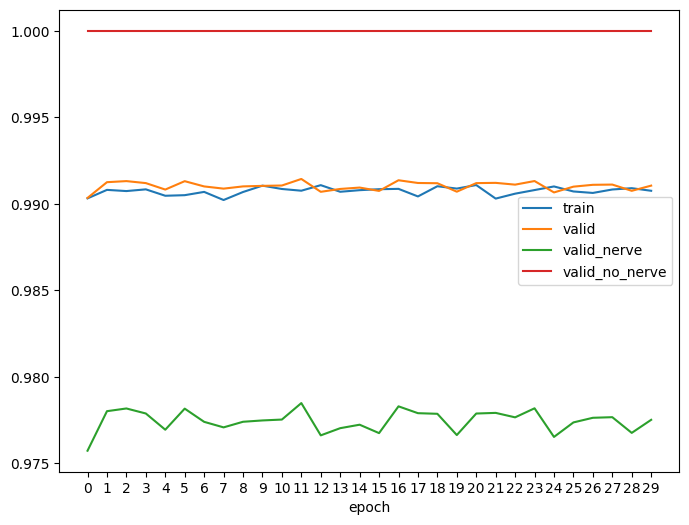

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plot_train_validate(resnet34_imagenet_log, ax)

Of course, the usual dice loss is not differentiable and the model (with the current learning rate) performs very poorly. We shall thus try some other differentiable loss functions.

### Soft Dice Loss

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

resnet34_imagenet_model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=resnet34_imagenet_model.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['loss'] = DiceLoss()
config['metrics'] += [DiceLoss()]

resnet34_imagenet_log = train_validate(preprocess=preprocess, model=resnet34_imagenet_model, optim=optim, **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 52.83it/s, soft_dice - 0.9246, hard_dice - 0.9097]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 57.49it/s, soft_dice - 0.8046, hard_dice - 0.782]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 56.01it/s, soft_dice - 0.7374, hard_dice - 0.7334]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 54.43it/s, soft_dice - 0.7018, hard_dice - 0.7009]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 55.94it/s, soft_dice - 0.7144, hard_dice - 0.7138]

Epoch: 5
valid: 100%|██████████| 211/211 [00:03<00:00, 56.00it/s, soft_dice - 0.7167, hard_dice - 0.676]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 56.68it/s, soft_dice - 0.6967, hard_dice - 0.6963]

Epoch: 7
valid: 100%|██████████| 211/211 [00:03<00:00, 52.83it/s, soft_dice - 0.7092, hard_dice - 0.7089]

Epoch: 8
vali

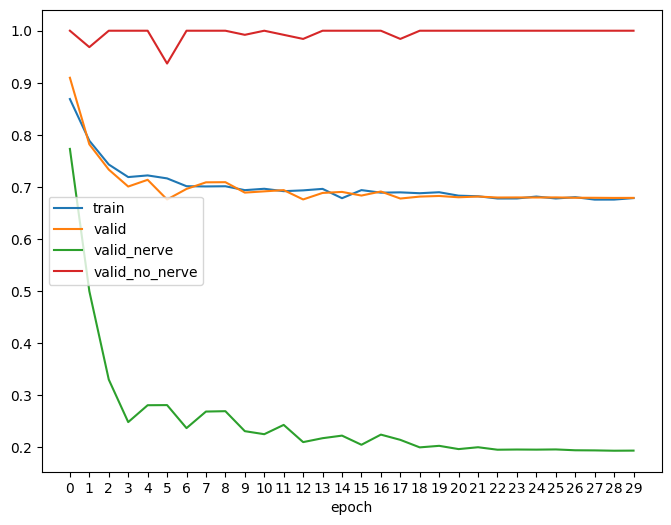

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plot_train_validate(resnet34_imagenet_log, ax)

In [ ]:
resnet34_imagenet_pred = predict_compare(valid_msks,
                                         resnet34_imagenet_model,
                                         color=True,
                                         preprocess=preprocess,
                                         metrics=[DiceLoss(), DiceLoss(soft=False)])

100%|██████████| 211/211 [00:03<00:00, 56.45it/s]


<Axes: xlabel='gt_mask_size', ylabel='pred_mask_size'>

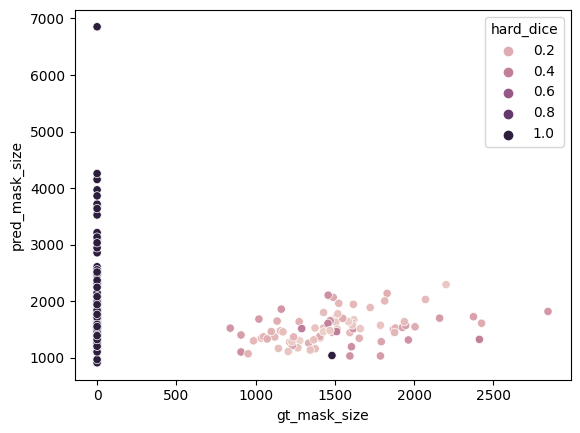

In [ ]:
sns.scatterplot(data=resnet34_imagenet_pred, x='gt_mask_size', y='pred_mask_size', hue='hard_dice')

Although the performance definitely improved compared to the model trained with hard Dice loss, it is not optimal. Especially, the output log from training and above graph show that the model, despite performing quite well when there are nerves present in the image, does not seem to predict the absence of nerves. This especially hurts the overall Dice loss of the model as any nontrivial mask, regardless of its size, will result in Dice loss of 1 if the image contains no nerve.

### BCE loss + (hard) Dice loss

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

resnet34_imagenet_model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=resnet34_imagenet_model.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['loss'] = ComboLoss()
config['metrics'].insert(0, BCELoss()) # so we can track the contribution of BCELoss to the total loss.

resnet34_imagenet_log = train_validate(preprocess=preprocess, model=resnet34_imagenet_model, optim=optim, **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 62.01it/s, BCE_hard_dice - 0.4262, bce - 0.07193, hard_dice - 0.7804]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 58.39it/s, BCE_hard_dice - 0.2479, bce - 0.04147, hard_dice - 0.4542]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 61.91it/s, BCE_hard_dice - 0.3541, bce - 0.05539, hard_dice - 0.6528]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 62.18it/s, BCE_hard_dice - 0.2535, bce - 0.03512, hard_dice - 0.472]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 60.38it/s, BCE_hard_dice - 0.2271, bce - 0.02913, hard_dice - 0.4251]

Epoch: 5
valid: 100%|██████████| 211/211 [00:03<00:00, 61.51it/s, BCE_hard_dice - 0.171, bce - 0.02514, hard_dice - 0.3169]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 61.04it/s, BCE_hard_dice - 0.2042, bce - 0.02624, hard_dic

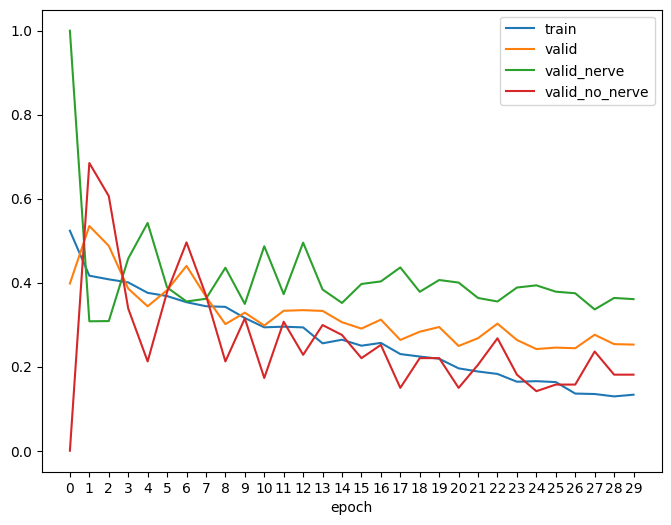

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plot_train_validate(resnet34_imagenet_log, ax)

In [ ]:
resnet34_imagenet_pred = predict_compare(valid_msks,
                                         resnet34_imagenet_model,
                                         color=True,
                                         preprocess=preprocess,
                                         metrics=[DiceLoss(), DiceLoss(soft=False)])

100%|██████████| 211/211 [00:03<00:00, 58.58it/s]


<Axes: xlabel='gt_mask_size', ylabel='pred_mask_size'>

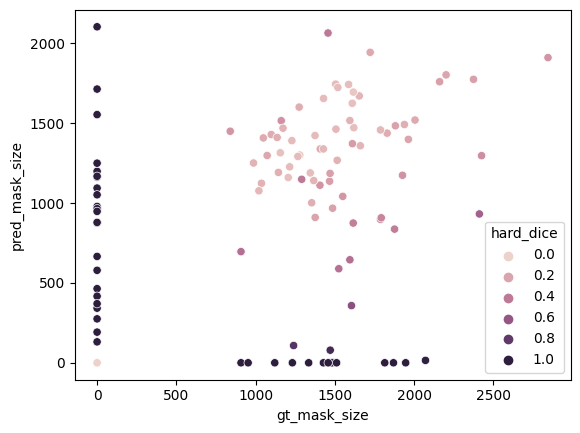

In [ ]:
sns.scatterplot(data=resnet34_imagenet_pred, x='gt_mask_size', y='pred_mask_size', hue='hard_dice')

We save the best model before we move to the next section.

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

resnet34_imagenet_model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
optim = torch.optim.Adam([dict(params=resnet34_imagenet_model.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['loss'] = ComboLoss()
config['metrics'].insert(0, BCELoss()) # so we can track the contribution of BCELoss to the total loss.
config['save_path'] = modelspath + 'seg_resnet34.pth'

train_validate(preprocess=preprocess, model=resnet34_imagenet_model, optim=optim, **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 59.50it/s, BCE_hard_dice - 0.235, bce - 0.07184, hard_dice - 0.3981]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 57.49it/s, BCE_hard_dice - 0.2193, bce - 0.03779, hard_dice - 0.4009]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 59.20it/s, BCE_hard_dice - 0.2297, bce - 0.03133, hard_dice - 0.428]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 57.60it/s, BCE_hard_dice - 0.2134, bce - 0.02794, hard_dice - 0.3988]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 58.51it/s, BCE_hard_dice - 0.2372, bce - 0.03072, hard_dice - 0.4437]

Epoch: 5
valid: 100%|██████████| 211/211 [00:03<00:00, 59.51it/s, BCE_hard_dice - 0.2307, bce - 0.03079, hard_dice - 0.4306]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 56.87it/s, BCE_hard_dice - 0.1844, bce - 0.02595, hard_dic

,epoch,type,bce,hard_dice
0,0,train,0.197958,0.613728
1,0,valid_no_nerve,0.054949,0.000000
2,0,valid_nerve,0.097369,1.000000
3,0,valid,0.071837,0.398104
4,1,train,0.048051,0.420802
...,...,...,...,...
115,28,valid,0.023891,0.263152
116,29,train,0.011516,0.118633
117,29,valid_no_nerve,0.009245,0.220472
118,29,valid_nerve,0.046803,0.356389


# Combining classification with segmentation

Unfortunately, the original implementation of Dice loss has a minor mistake, which resulted in significantly higher loss in data with no nerve. We attempted to merge a classification model to control the loss coming from this set. This is because with some assumptions (for example, the validation samples with nerves is homogeneous, and the average loss won't change drastically on a subset of a reasonable size), combining a classification model with a segmentation model, we could expect the Dice loss will improve to

<center>$\displaystyle
\frac{\text{tp}}{\text{all}}\cdot 0.2
+ \frac{\text{tn}}{\text{all}}\cdot 0
+ (1-\text{accuracy})\cdot 1$.</center>

However, once the error in Dice loss is fixed, the UNet model (with pre-trained ResNet34) performed better on images with no nerve and this no longer became an issue. Given that there are more images without nerves, this perhaps was to be expected. Regardless, as a misclassified (in terms of the presence of a nerve) can lead to the maximum loss of $1$, correctly classifying each image should still be important in building a well-performing segmentation model. Thus, in this section, we aim to incorporate classification into segmentation model in multiple ways.


## Classification loss functions

In [114]:
from torchvision.models import resnet34, ResNet34_Weights

from torcheval.metrics import Cat, BinaryAccuracy, BinaryF1Score
from torcheval.metrics.functional import binary_accuracy, binary_precision, binary_recall, binary_f1_score

In [123]:
class BCELoss(nn.Module):
    def __init__(self, weights=(1,1), modulate=0, reduce=torch.mean):
        super().__init__()
        self.weights = weights
        self.reduce = reduce
        self.gamma = modulate
        self.__name__ = 'bce'

    def forward(self, output, target):
        p_t = target*output + (1-target)*(1-output)

        output = torch.clamp(output, min=-100)
        log0, log1 = torch.log(output), torch.log(1-output)
        log0[torch.isinf(log0)] = -100
        log1[torch.isinf(log1)] = -100

        loss = self.weights[0]*target*log0 + self.weights[1]*(1-target)*log1
        loss = (1-p_t)**self.gamma * loss
        return self.reduce(-loss)


class ClassificationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.__name__ = None

    def forward(self, output, target):
        pass

    def counts(self, output, target):
        output = torch.round(output)
        tp = torch.sum(output*target)
        tn = torch.sum((1-output)*(1-target))
        fp = torch.sum(output*(1-target))
        fn = torch.sum((1-output)*target)
        return tp, tn, fp, fn



class Accuracy(ClassificationLoss):
    def __init__(self, epsilon = 1e-7, as_loss = False):
        super().__init__()
        self.epsilon = epsilon
        self.as_loss = as_loss
        self.__name__ = 'accuracy' + ' loss'*as_loss

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        acc = (tp+tn) / (tp+fn+tn+fp + self.epsilon)
        if self.as_loss:
            return 1-torch.mean(acc)
        return torch.mean(acc)



class Precision(ClassificationLoss):
    def __init__(self, epsilon = 1e-7, as_loss = False):
        super().__init__()
        self.epsilon = epsilon
        self.as_loss = as_loss
        self.__name__ = 'precision' + ' loss'*as_loss

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        prec = tp / (tp+fp + self.epsilon)
        if self.as_loss:
            return 1-torch.mean(prec)
        return torch.mean(prec)



class Recall(ClassificationLoss):
    def __init__(self, epsilon = 1e-7, as_loss = False):
        super().__init__()
        self.epsilon = epsilon
        self.as_loss = as_loss
        self.__name__ = 'recall' + ' loss'*as_loss

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        rec = tp / (tp+fn + self.epsilon)
        if self.as_loss:
            return 1-torch.mean(rec)
        return torch.mean(rec)



class F1Score(ClassificationLoss):
    def __init__(self, epsilon = 1e-7, as_loss = False):
        super().__init__()
        self.epsilon = epsilon
        self.as_loss = as_loss
        self.__name__ = 'f1' + ' loss'*as_loss

    def forward(self, output, target):
        tp, tn, fp, fn = self.counts(output, target)
        f1 = 2*tp / (2*tp+fn+fp + self.epsilon)
        if self.as_loss:
            return 1-torch.mean(f1)
        return torch.mean(f1)

## Definitions for classification training

In [116]:
class ClassDataset(Dataset):
    def __init__(self, mskfiles, color=True, preprocess=None, augment=None, train=True):
        super().__init__()

        self.mskfiles = [trainpath+o for o in mskfiles]
        self.imgfiles = [o.replace('_mask', '') for o in self.mskfiles]

        self.preprocess = preprocess
        self.augment = augment
        self.color = color


    def __len__(self):
        return len(self.mskfiles)


    def __getitem__(self, idx):
        if self.color:
            img = cv2.imread(self.imgfiles[idx])
        else:
            img = cv2.imread(self.imgfiles[idx], cv2.IMREAD_GRAYSCALE)

        msk = cv2.imread(self.mskfiles[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment is not None:
            sample = self.augment(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if self.preprocess is not None:
            sample = self.preprocess(image = img, mask = msk)
            img, msk = sample['image'], sample['mask']

        if not self.color:
            img = np.expand_dims(img, axis=0)

        img = img.astype(np.float32)
        label = 1 if msk.any() else 0
        label = np.expand_dims(label, axis=0)

        return img, label

The log for ClassTrainEpoch shows running average of loss/metric over batches while the log for ClassValidEpoch shows the running average over validation data. This is because we choose a model based on its performance on the validation set and I wanted actual average over the entire validation data.

In [117]:
class ClassTrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        #prediction = self.model.forward(x)
        prediction = self.model(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction



class ClassValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )


    def on_epoch_start(self):
        self.model.eval()


    def batch_update(self, x, y):
        with torch.no_grad():
            #prediction = self.model.forward(x)
            prediction = self.model(x)
            loss = self.loss(prediction, y)
        return loss, prediction


    @torch.no_grad()
    def run(self, dataloader):
        self.on_epoch_start()

        # loss_meter = AverageValueMeter()
        # metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}
        # batch_count = 0
        predictions, ys = [], []
        logs = {}
        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                ys.append(y)
                predictions.append(self.model(x))

                #pdb.set_trace()
                prediction, y = torch.cat(predictions, 0), torch.cat(ys, 0)
                predictions, ys = [prediction], [y]

                # update loss logs
                loss = self.loss(prediction, y)
                loss_logs = {self.loss.__name__: loss.item()}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(prediction, y).item()
                    logs.update({metric_fn.__name__: metric_value})

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs

In [118]:
def classify_validate(train_msks, valid_msks, preprocess, augment, model, optim,
                   color=True, loss=DiceLoss(soft=True), metrics=[DiceLoss(soft=True), DiceLoss(soft=False)],
                   device='cuda', batch_size=16, epochs=5,
                   save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    traindata = ClassDataset(mskfiles=train_msks, color=color, preprocess=preprocess, augment=augment)
    validdata = ClassDataset(mskfiles=valid_msks, color=color, preprocess=preprocess)

    trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
    validloader = DataLoader(validdata, batch_size = batch_size)

    trainepoch = ClassTrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics)
    validepoch = ClassValidEpoch(model, device=device, loss=loss, metrics=metrics)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

    if stop_early:
        stopper = EarlyStopper()

    columns = ['epoch', 'type', loss.__name__] + [metric.__name__ for metric in metrics]
    loss_log = pd.DataFrame(columns=columns)
    for i in range(epochs):
        print('\nEpoch: {}'.format(i))
        trainlogs = trainepoch.run(trainloader)
        validlogs = validepoch.run(validloader)

        train_loss = {'epoch': i, 'type': 'train'}
        valid_loss = {'epoch': i, 'type': 'valid'}

        train_loss.update({loss.__name__: trainlogs[loss.__name__]})
        train_loss.update(dict([(metric.__name__, trainlogs[metric.__name__]) for metric in metrics]))

        valid_loss.update({loss.__name__: validlogs[loss.__name__]})
        valid_loss.update(dict([(metric.__name__, validlogs[metric.__name__]) for metric in metrics]))

        loss_log.loc[len(loss_log)] = train_loss
        loss_log.loc[len(loss_log)] = valid_loss

        save_loss = validlogs[save_metric]
        if save_path is not None and save_loss < save_thres:
            save_thres = save_loss
            torch.save(model, save_path)

        if stop_early:
            if stopper.early_stop(valid_loss[save_metric]):
                print('Early stop triggered.')
                break
            print(f'Valid Loss: {valid_loss[save_metric]:.4}, Stopper: min_validation_loss {stopper.min_validation_loss:.4}, counter {stopper.counter}.')

        lr_scheduler.step()

    return loss_log

In [119]:
class ClassificationModel(nn.Module):
    def __init__(self, conv_model=torchvision.models.resnet34, conv_weights=ResNet34_Weights.DEFAULT, activation=nn.Sigmoid):
        super().__init__()
        self.conv_model = conv_model(weights=conv_weights)
        self.classification_head = nn.Sequential(OrderedDict(
            {
                'linear': nn.Linear(1000, 1, bias=True),
                'activation': activation()
            }
        ))

    def forward(self, x):
        features = self.conv_model(x)
        prob = self.classification_head(features)
        return prob

In [120]:
def load_classify_config():
    return {
        'train_msks': train_msks,
        'valid_msks': valid_msks,
        'augment': albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                            albumentations.HorizontalFlip()]),
        'loss': BCELoss(),
        'metrics': [Accuracy(), Precision(), Recall(), F1Score()],
        'device': 'cuda',
        'batch_size': 16,
        'epochs': 15,
        'save_thres': 1e6, 'save_metric': 'f1', 'save_path': None,
        'stop_early': False
        }

# Naive combination

As our first attempt, we naively combine results from a classification model and segmentation model (i.e. multiply the predicted mask with the outcome of a classification model).


In [121]:
class SimpleCombinedModel(nn.Module):
    def __init__(self, seg_model, class_model, alpha=1):
        super().__init__()
        self.segmentation = torch.load(modelspath + seg_model)
        self.classification = torch.load(modelspath + class_model)
        self.alpha = alpha

    def forward(self, x):
        seg_output = self.segmentation(x)
        class_output = self.classification(x)
        #pdb.set_trace()
        return (class_output**self.alpha) * seg_output

## Classification with BCE loss

In [77]:
model = ClassificationModel(conv_weights = ResNet34_Weights.DEFAULT)
optim = torch.optim.Adam([dict(params=model.conv_model.parameters(), lr=1e-4),
                          dict(params=model.classification_head.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocess = albumentations.Compose([albumentations.Resize(height=256, width=256, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
config['epochs'] = 10
#config['save_path'] = modelspath + 'class_resnet34.pth'

class_BCE_log = classify_validate(model=model,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)


Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00,  7.70it/s, bce - 0.6593, accuracy - 0.6919, precision - 0.6667, recall - 0.4524, f1 - 0.539]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00,  7.97it/s, bce - 0.6158, accuracy - 0.7204, precision - 0.7358, recall - 0.4643, f1 - 0.5693]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00,  7.65it/s, bce - 0.4574, accuracy - 0.7962, precision - 0.7733, recall - 0.6905, f1 - 0.7296]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00,  8.00it/s, bce - 0.557, accuracy - 0.7393, precision - 0.6198, recall - 0.8929, f1 - 0.7317]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00,  7.63it/s, bce - 0.4718, accuracy - 0.7867, precision - 0.7407, recall - 0.7143, f1 - 0.7273]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s, bce - 0.5565, accuracy - 0.7867, precision - 0.7053, recall - 0.7976, f1 - 0.7486]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00,  7.63it/s, bce - 0.6602, accuracy - 0.7678, precision - 0.68

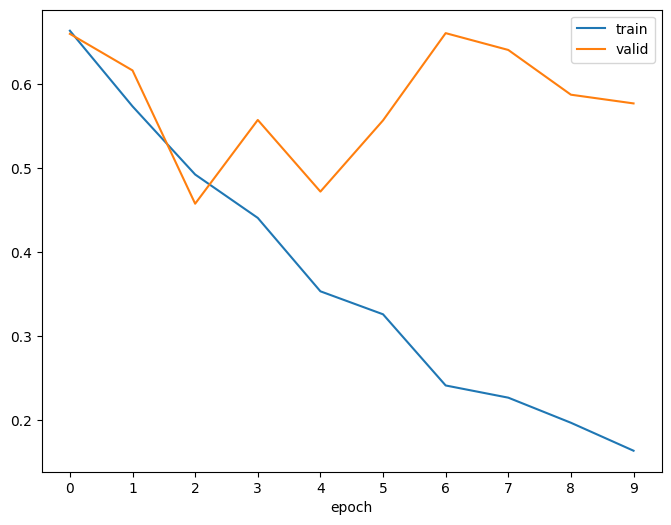

In [78]:
log = class_BCE_log

fig, ax = plt.subplots(figsize=(8,6))
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='bce', ax=ax, label=type, xticks=xticks);
plt.legend()

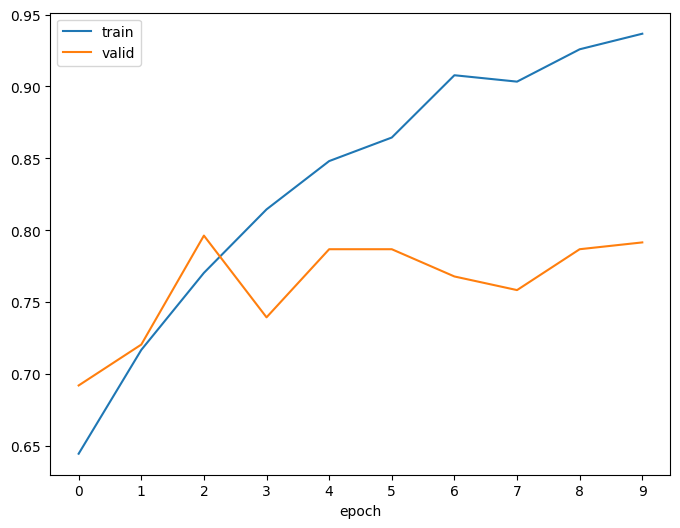

In [79]:
log = class_BCE_log

fig, ax = plt.subplots(figsize=(8,6))
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='accuracy', ax=ax, label=type, xticks=xticks);
plt.legend()

Both BCE and accuracy stop improving on the validation set after the first couple of epochs. It can be an extreme case of overfitting or just a poor choice of the loss function (or both?)

What if we tweak the BCE loss as little? Let's try to introduce modulating factor (like the one in focal loss) in BCE loss. Hopefully this will prevent the model from "over-learning" easier examples.

### Classification with tweaked BCE loss I

In [125]:
model = ClassificationModel(conv_weights = ResNet34_Weights.DEFAULT)
optim = torch.optim.Adam([dict(params=model.conv_model.parameters(), lr=1e-4),
                          dict(params=model.classification_head.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocess = albumentations.Compose([albumentations.Resize(height=256, width=256, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
config['loss'] = BCELoss(weights=(1.1,1), modulate=2)
config['epochs'] = 10
#config['save_path'] = modelspath + 'class_resnet34.pth'

class_BCE_log = classify_validate(model=model,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)


Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00,  7.46it/s, bce - 0.2257, accuracy - 0.5592, precision - 0.4698, recall - 0.8333, f1 - 0.6009]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00,  7.68it/s, bce - 0.1735, accuracy - 0.7156, precision - 0.7222, recall - 0.4643, f1 - 0.5652]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00,  7.47it/s, bce - 0.1621, accuracy - 0.7014, precision - 0.6, recall - 0.75, f1 - 0.6667]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00,  7.78it/s, bce - 0.1393, accuracy - 0.763, precision - 0.7297, recall - 0.6429, f1 - 0.6835]

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00,  7.24it/s, bce - 0.1648, accuracy - 0.7583, precision - 0.7705, recall - 0.5595, f1 - 0.6483]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00,  7.58it/s, bce - 0.1637, accuracy - 0.782, precision - 0.6979, recall - 0.7976, f1 - 0.7444]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00,  7.09it/s, bce - 0.1491, accuracy - 0.7678, precision - 0.6842, r

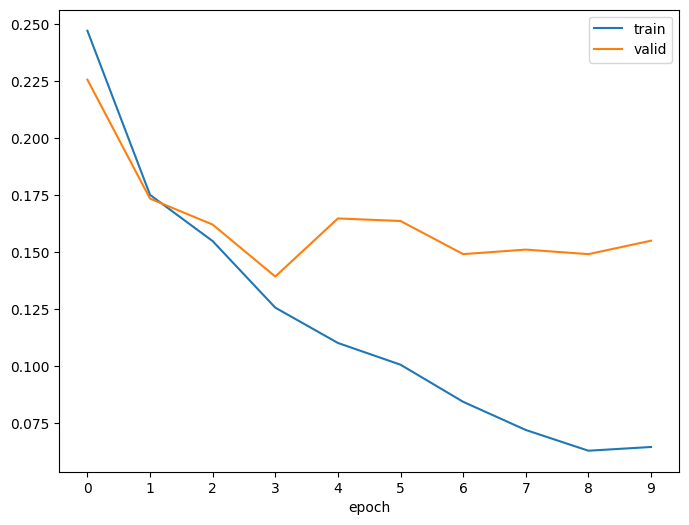

In [128]:
log = class_BCE_log

fig, ax = plt.subplots(figsize=(8,6))
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='bce', ax=ax, label=type, xticks=xticks);
plt.legend()

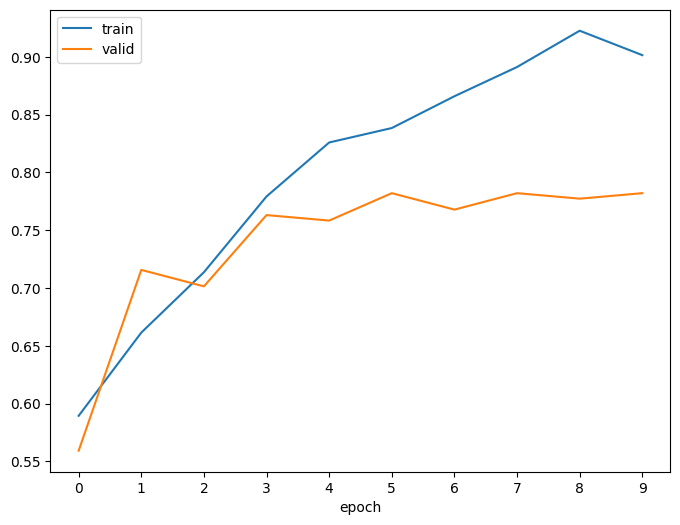

In [127]:
log = class_BCE_log

fig, ax = plt.subplots(figsize=(8,6))
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='accuracy', ax=ax, label=type, xticks=xticks);
plt.legend()

There's little improvement but the model still stops improving after first couple of epochs.

Perhaps I should try a simpler model?

### Classification with tweaked BCE loss II

In [129]:
model = ClassificationModel(conv_weights = ResNet34_Weights.DEFAULT)
optim = torch.optim.Adam([dict(params=model.conv_model.parameters(), lr=1e-4),
                          dict(params=model.classification_head.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocess = albumentations.Compose([albumentations.Resize(height=256, width=256, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
config['loss'] = BCELoss(weights=(1.1,1), modulate=4)
config['epochs'] = 10
#config['save_path'] = modelspath + 'class_resnet34.pth'

class_BCE_log = classify_validate(model=model,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)


Epoch: 0
valid: 100%|██████████| 14/14 [00:02<00:00,  6.73it/s, bce - 0.0754, accuracy - 0.5261, precision - 0.4535, recall - 0.9286, f1 - 0.6094]

Epoch: 1
valid: 100%|██████████| 14/14 [00:02<00:00,  6.83it/s, bce - 0.03833, accuracy - 0.6872, precision - 0.5918, recall - 0.6905, f1 - 0.6374]

Epoch: 2
valid: 100%|██████████| 14/14 [00:02<00:00,  5.87it/s, bce - 0.04086, accuracy - 0.7488, precision - 0.7818, recall - 0.5119, f1 - 0.6187]

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00,  7.27it/s, bce - 0.06067, accuracy - 0.6635, precision - 0.5455, recall - 0.9286, f1 - 0.6872]

Epoch: 4
valid: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s, bce - 0.04038, accuracy - 0.7583, precision - 0.7143, recall - 0.6548, f1 - 0.6832]

Epoch: 5
valid: 100%|██████████| 14/14 [00:02<00:00,  5.73it/s, bce - 0.04325, accuracy - 0.7204, precision - 0.6016, recall - 0.881, f1 - 0.715]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00,  7.40it/s, bce - 0.04293, accuracy - 0.782, precision -

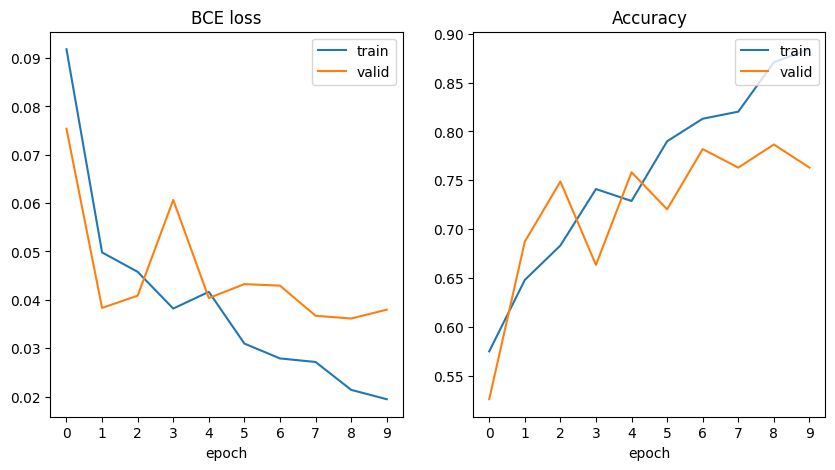

In [131]:
log = class_BCE_log

fig, axs = plt.subplots(1, 2, figsize=(10,5))

# plot bce loss
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='bce', ax=axs[0], label=type, xticks=xticks);
axs[0].legend(loc="upper right");
axs[0].set_title('BCE loss');


# plot accuracy
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='accuracy', ax=axs[1], label=type, xticks=xticks);
axs[1].legend(loc="upper right");
axs[1].set_title('Accuracy');

It looks very slightly better.

Let's try a simpler model.

### Training with ResNet18

In [132]:
from torchvision.models import resnet18, ResNet18_Weights

In [134]:
model = ClassificationModel(conv_model=torchvision.models.resnet18, conv_weights = ResNet18_Weights.DEFAULT)
optim = torch.optim.Adam([dict(params=model.conv_model.parameters(), lr=1e-4),
                          dict(params=model.classification_head.parameters(), lr=1e-3)])

preprocess_fn = smp.encoders.get_preprocessing_fn('resnet18', 'imagenet')
preprocess = albumentations.Compose([albumentations.Resize(height=256, width=256, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
config['loss'] = BCELoss(weights=(1.1,1), modulate=4)
config['epochs'] = 10
#config['save_path'] = modelspath + 'class_resnet34.pth'

class_BCE_log = classify_validate(model=model,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.8MB/s]



Epoch: 0
valid: 100%|██████████| 14/14 [00:01<00:00,  7.60it/s, bce - 0.07963, accuracy - 0.5403, precision - 0.4575, recall - 0.8333, f1 - 0.5907]

Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00,  7.83it/s, bce - 0.1305, accuracy - 0.6588, precision - 0.9286, recall - 0.1548, f1 - 0.2653]

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00,  7.15it/s, bce - 0.04319, accuracy - 0.6872, precision - 0.6324, recall - 0.5119, f1 - 0.5658]

Epoch: 3
valid: 100%|██████████| 14/14 [00:02<00:00,  6.94it/s, bce - 0.0425, accuracy - 0.7204, precision - 0.6812, recall - 0.5595, f1 - 0.6144]

Epoch: 4
valid: 100%|██████████| 14/14 [00:02<00:00,  6.14it/s, bce - 0.04018, accuracy - 0.7346, precision - 0.6489, recall - 0.7262, f1 - 0.6854]

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00,  7.18it/s, bce - 0.04403, accuracy - 0.7536, precision - 0.7105, recall - 0.6429, f1 - 0.675]

Epoch: 6
valid: 100%|██████████| 14/14 [00:01<00:00,  7.69it/s, bce - 0.04064, accuracy - 0.7156, precision 

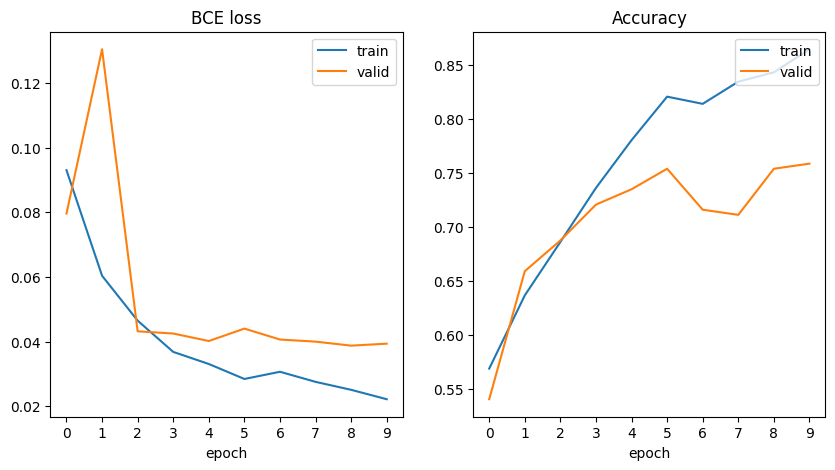

In [135]:
log = class_BCE_log

fig, axs = plt.subplots(1, 2, figsize=(10,5))

# plot bce loss
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='bce', ax=axs[0], label=type, xticks=xticks);
axs[0].legend(loc="upper right");
axs[0].set_title('BCE loss');


# plot accuracy
xticks = range(log['epoch'].max()+1)
for type, df in log.groupby('type'):
    df.plot(x='epoch', y='accuracy', ax=axs[1], label=type, xticks=xticks);
axs[1].legend(loc="upper right");
axs[1].set_title('Accuracy');

The model definitely learns more slowly but at least accuracy continues to improve till the sixth epoch (and possibly after the eigth epoch as well). Perhaps I should test it for more epochs but I wonder if it the validation performance will stop improving after a certain threshold (~0.75 accuracy). Maybe I should pause here and see what the accuracy for segmentation model from previous section is.

### Checking the accuracy of the segmentation model

In [137]:
seg_model = torch.load(modelspath + 'seg_resnet34.pth')

In [138]:
preprocess_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocess = albumentations.Compose([albumentations.Resize(height=256, width=256, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

seg_log = predict_compare(valid_msks,
                        seg_model,
                        color=True,
                        preprocess=preprocess,
                        metrics=[DiceLoss(), DiceLoss(soft=False)])

100%|██████████| 211/211 [00:04<00:00, 46.22it/s]


### Combining classification and segmentation naively

This part needs to be updated once a model for classification is decided.

In [ ]:
test_model = SimpleCombinedModel(seg_model = 'seg_resnet34.pth', class_model = 'class_resnet34.pth')

In [ ]:
test_log = predict_compare(valid_msks, test_model, color=True, preprocess=preprocess, metrics=[DiceLoss(soft=True), DiceLoss(soft=False)], device='cuda')

100%|██████████| 211/211 [00:04<00:00, 47.93it/s]


In [ ]:
test_log.describe()

,soft_dice,hard_dice,gt_mask_size,pred_mask_size
count,211.000000,211.000000,211.000000,211.000000
mean,0.858894,0.315443,789.488152,204.990521
std,0.242137,0.441307,1021.357166,526.218549
min,0.170668,0.000000,0.000000,0.000000
25%,0.792189,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1815.500000,0.000000
max,1.000000,1.000000,3720.000000,2181.000000


<Axes: xlabel='gt_mask_size', ylabel='pred_mask_size'>

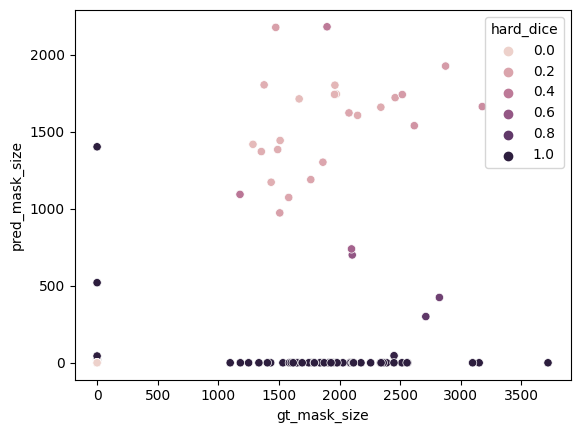

In [ ]:
sns.scatterplot(data=test_log, x='gt_mask_size', y='pred_mask_size', hue='hard_dice')

# To-do List

0. Check the discrepancy between soft_dice and hard_dice (by looking at some images--the ones with larger discrepancy). On second thought, since anything below 0.5 gets rounded down to 0 with hard_dice, the difference of ~0.5 makes sense?
1. Classification and segmentation in one model instead of having two separate models (start with UNet decoder implementation--the one from before will probably need some modifications).
2. Probability or {0,1}?
3. Classification model can be improved.
4. Multitask learning (a relevant paper: https://github.com/vivien000/auxiliary-learning2/blob/master/auxiliary_tasks.pdf).



# Combining classification and segmentation

Modifying Segmentation Model from smp.

In [ ]:
# Good idea to import all these?
from segmentation_models_pytorch.base import SegmentationHead, ClassificationHead
from segmentation_models_pytorch.base.model import SegmentationModel
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder
from segmentation_models_pytorch.encoders import get_encoder

In [ ]:
from typing import Optional, List, Union, TypeVar

In [ ]:
class ModifiedUnet(SegmentationModel):
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet", # Let's initialize with the default wts and update afterwards if necessary.
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = {'classes':1, 'pooling':'avg', 'dropout':0.2, 'activation':'sigmoid'},
        classify: bool = False,
        round: bool = False
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        #self.classification_head = ClassificationHead(in_channels=self.encoder.out_channels[-1], **aux_params)
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.encoder.out_channels[-1], 1, bias=True),
            nn.Sigmoid()
        )

        self.classify = classify
        self.round = round

        self.name = "modified-u-{}".format(encoder_name)
        self.initialize()


    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""
        self.check_input_shape(x)

        features = self.encoder(x)
        labels = self.classification_head(features[-1])

        if self.classify:
            return labels

        decoder_output = self.decoder(*features)
        masks = self.segmentation_head(decoder_output)

        #pdb.set_trace()
        if self.round:
            return torch.round(labels.view(-1,1,1,1))*masks
        return labels.view(-1,1,1,1)*masks


    def enable_segmentation(self):
        self.classify = False
        for child in self.decoder.children():
            for param in child.parameters():
                param.requires_grad = not self.classify

        for child in self.segmentation_head:
            for param in child.parameters():
                param.requires_grad = not self.classify


    def disable_segmentation(self):
        self.classify = True
        for child in self.decoder.children():
            for param in child.parameters():
                param.requires_grad = not self.classify

        for child in self.segmentation_head:
            for param in child.parameters():
                param.requires_grad = not self.classify


    def freeze_classification(self):
        for child in self.encoder.children():
            for param in child.parameters():
                param.requires_grad = False

        for child in self.classification_head:
            for param in child.parameters():
                param.requires_grad = False


    def unfreeze_classification(self):
        for child in self.encoder.children():
            for param in child.parameters():
                param.requires_grad = True

        for child in self.classification_head:
            for param in child.parameters():
                param.requires_grad = True

In [ ]:
ModifiedUnet()

ModifiedUnet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

## Train all parts together

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

mod_all = ModifiedUnet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
mod_all.enable_segmentation()

optim = torch.optim.Adam([dict(params=mod_all.encoder.parameters(), lr=1e-3),
                          dict(params=mod_all.decoder.parameters(), lr=3e-3),
                          dict(params=mod_all.classification_head.parameters(), lr=3e-3),
                          dict(params=mod_all.segmentation_head.parameters(), lr=3e-3)
                          ])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['epochs'] = 10

mod_all_log = train_validate(model=mod_all,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 60.99it/s, soft_dice - 0.9314, hard_dice - 0.9314]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 62.99it/s, soft_dice - 0.7263, hard_dice - 0.7263]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 65.58it/s, soft_dice - 0.705, hard_dice - 0.705]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 53.20it/s, soft_dice - 0.7049, hard_dice - 0.7049]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 59.39it/s, soft_dice - 0.7005, hard_dice - 0.7005]

Epoch: 5
valid: 100%|██████████| 211/211 [00:04<00:00, 50.24it/s, soft_dice - 0.6854, hard_dice - 0.6854]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 63.01it/s, soft_dice - 0.6895, hard_dice - 0.6895]

Epoch: 7
valid: 100%|██████████| 211/211 [00:03<00:00, 66.53it/s, soft_dice - 0.6911, hard_dice - 0.6911]

Epoch: 8
vali

## Train the classifier first

First train the encoder & the classification_head.

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

mod_sep = ModifiedUnet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
mod_sep.disable_segmentation()

optim = torch.optim.Adam([dict(params=mod_sep.encoder.parameters(), lr=1e-3),
                          dict(params=mod_sep.classification_head.parameters(), lr=1e-3)
                          ])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
config['epochs'] = 20

mod_sep_log = classify_validate(model=mod_sep,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)


Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 65.25it/s, bce - 0.6204, accuracy - 0.6256, precision - 0.1943, recall - 0.1943, f1 - 0.1943]

Epoch: 1
valid: 100%|██████████| 211/211 [00:02<00:00, 71.62it/s, bce - 0.55, accuracy - 0.7156, precision - 0.3081, recall - 0.3081, f1 - 0.3081]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 65.81it/s, bce - 0.6042, accuracy - 0.6588, precision - 0.3412, recall - 0.3412, f1 - 0.3412]

Epoch: 3
valid: 100%|██████████| 211/211 [00:02<00:00, 72.36it/s, bce - 0.504, accuracy - 0.7488, precision - 0.2275, recall - 0.2275, f1 - 0.2275]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 65.11it/s, bce - 0.6304, accuracy - 0.7062, precision - 0.3697, recall - 0.3697, f1 - 0.3697]

Epoch: 5
valid: 100%|██████████| 211/211 [00:02<00:00, 70.96it/s, bce - 0.682, accuracy - 0.7109, precision - 0.346, recall - 0.346, f1 - 0.346]

Epoch: 6
valid: 100%|██████████| 211/211 [00:03<00:00, 65.33it/s, bce - 0.6478, accuracy - 0.7299, precisi

Both precision and recall are much worse compared to accuracy. Although it's the accuracy that we mostly care bout, let's still try adding some weights to the BCE loss before moving on the second part of the training.



In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

mod_sep = ModifiedUnet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
mod_sep.disable_segmentation()

optim = torch.optim.Adam([dict(params=mod_sep.encoder.parameters(), lr=3e-4), # lr lowered to avoid nans.
                          dict(params=mod_sep.classification_head.parameters(), lr=1e-3)
                          ])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
config['epochs'] = 10 # model seems to overfit pretty quickly
config['loss'] = BCELoss(weights=(1,1.25))

mod_sep_log = classify_validate(model=mod_sep,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)


Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 69.00it/s, bce - 0.7659, accuracy - 0.6209, precision - 0.1232, recall - 0.1232, f1 - 0.1232]

Epoch: 1
valid: 100%|██████████| 211/211 [00:02<00:00, 70.84it/s, bce - 0.6522, accuracy - 0.6777, precision - 0.08531, recall - 0.08531, f1 - 0.08531]

Epoch: 2
valid: 100%|██████████| 211/211 [00:02<00:00, 71.97it/s, bce - 0.6138, accuracy - 0.7488, precision - 0.3081, recall - 0.3081, f1 - 0.3081]

Epoch: 3
valid: 100%|██████████| 211/211 [00:02<00:00, 71.88it/s, bce - 0.6816, accuracy - 0.7204, precision - 0.1517, recall - 0.1517, f1 - 0.1517]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 68.49it/s, bce - 0.6063, accuracy - 0.7488, precision - 0.327, recall - 0.327, f1 - 0.327]

Epoch: 5
valid: 100%|██████████| 211/211 [00:02<00:00, 71.40it/s, bce - 0.5765, accuracy - 0.7536, precision - 0.2559, recall - 0.2559, f1 - 0.2559]

Epoch: 6
valid: 100%|██████████| 211/211 [00:02<00:00, 70.96it/s, bce - 0.5416, accuracy - 0.7867, 

We now train the entire model, with very very small learning rates for the encoder and the classification head (should I just freeze these?) We will also use ComboLoss.

In [ ]:
mod_sep.enable_segmentation()

optim = torch.optim.Adam([dict(params=mod_sep.encoder.parameters(), lr=1e-6),
                          dict(params=mod_sep.decoder.parameters(), lr=1e-3),
                          dict(params=mod_sep.classification_head.parameters(), lr=1e-6),
                          dict(params=mod_sep.segmentation_head.parameters(), lr=1e-3)
                          ])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['loss'] = ComboLoss()
config['metrics'] += [BCELoss()]

mod_sep_log = train_validate(model=mod_sep,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)

211 samples in validation set: 84 with nerves 127 with no nerve.
Ratio of samples with nerves in validation set: 0.3981042654028436

Epoch: 0
valid: 100%|██████████| 211/211 [00:04<00:00, 43.35it/s, BCE_hard_dice - 0.3935, soft_dice - 0.7542, hard_dice - 0.7542, bce - 0.03278]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 63.21it/s, BCE_hard_dice - 0.3923, soft_dice - 0.7503, hard_dice - 0.7503, bce - 0.03439]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 58.06it/s, BCE_hard_dice - 0.3939, soft_dice - 0.752, hard_dice - 0.752, bce - 0.03586]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 60.28it/s, BCE_hard_dice - 0.3898, soft_dice - 0.747, hard_dice - 0.747, bce - 0.03271]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 62.93it/s, BCE_hard_dice - 0.387, soft_dice - 0.741, hard_dice - 0.741, bce - 0.03303]


## Freeze the encoder and the classification head altogether.

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

mod_freeze = ModifiedUnet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)
mod_freeze.disable_segmentation()

optim = torch.optim.Adam([dict(params=mod_freeze.encoder.parameters(), lr=3e-4), # lr lowered to avoid nans.
                          dict(params=mod_freeze.classification_head.parameters(), lr=1e-3)
                          ])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_classify_config()
config['epochs'] = 10 # model seems to overfit pretty quickly
config['loss'] = BCELoss(weights=(1,1.25))

mod_freeze_log = classify_validate(model=mod_freeze,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)


Epoch: 0
valid: 100%|██████████| 211/211 [00:03<00:00, 55.41it/s, bce - 0.6541, accuracy - 0.6872, precision - 0.2417, recall - 0.2417, f1 - 0.2417]

Epoch: 1
valid: 100%|██████████| 211/211 [00:03<00:00, 69.81it/s, bce - 0.5371, accuracy - 0.763, precision - 0.2464, recall - 0.2464, f1 - 0.2464]

Epoch: 2
valid: 100%|██████████| 211/211 [00:03<00:00, 65.07it/s, bce - 0.7131, accuracy - 0.7441, precision - 0.3507, recall - 0.3507, f1 - 0.3507]

Epoch: 3
valid: 100%|██████████| 211/211 [00:03<00:00, 62.26it/s, bce - 0.4765, accuracy - 0.8009, precision - 0.2417, recall - 0.2417, f1 - 0.2417]

Epoch: 4
valid: 100%|██████████| 211/211 [00:03<00:00, 64.89it/s, bce - 0.49, accuracy - 0.8152, precision - 0.3033, recall - 0.3033, f1 - 0.3033]


In [ ]:
mod_freeze.enable_segmentation()
mod_freeze.freeze_classification()

optim = torch.optim.Adam([dict(params=mod_freeze.decoder.parameters(), lr=1e-3),
                          dict(params=mod_freeze.segmentation_head.parameters(), lr=1e-3)
                          ])

preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_wts)
preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                     albumentations.Lambda(image=preprocess_fn),
                                     albumentations.Lambda(image=to_tensor)])

config = load_train_config()
config['loss'] = ComboLoss()
config['metrics'] += [BCELoss()]
config['epochs'] = 3

mod_freeze_log = train_validate(model=mod_freeze,
                                      optim=optim,
                                      preprocess=preprocess,
                                      **config)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plot_train_validate(mod_freeze_log, ax)

In [ ]:
test_log = predict_compare(valid_msks, mod_freeze, color=True, preprocess=preprocess, metrics=[DiceLoss(soft=True), DiceLoss(soft=False)], device='cuda')

100%|██████████| 211/211 [00:03<00:00, 62.99it/s]


In [ ]:
test_log.describe()

,soft_dice,hard_dice,gt_mask_size,pred_mask_size
count,211.000000,211.000000,211.000000,211.000000
mean,0.817410,0.269319,604.545024,416.545024
std,0.258663,0.392456,781.910019,682.064465
min,0.239869,0.000000,0.000000,0.000000
25%,0.584065,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.401357,1391.000000,974.500000
max,1.000000,1.000000,2845.000000,2424.000000


# Definitions for cross-validation

In [ ]:
default_model_config = {'encoder_name':'resnet34',
                        'encoder_weights':'imagenet',
                        'activation':'sigmoid'}

In [ ]:
def create_smp_Unet(freeze_bottleneck=False, model_config=default_model_config):
    model = smp.Unet(**model_config)

    if freeze_bottleneck:
        # Let's assume encoder = resnet34 or resnet18
        for i, child in enumerate(model.encoder.layer4.children()):
            if i > 0:
                for param in child.parameters():
                    param.requires_grad = False

    return model

In [ ]:
def create_optim(model, proto=torch.optim.Adam, lr=1e-3):
    optim = proto([dict(params=model.parameters(), lr=lr)])
    return optim

In [ ]:
def load_cv_config(freeze_bottleneck=True):
    augment = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                                    albumentations.HorizontalFlip()])

    preprocess_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
    preprocess = albumentations.Compose([albumentations.Resize(height=224, width=224, interpolation=Image.BILINEAR),
                                        albumentations.Lambda(image=preprocess_fn),
                                        albumentations.Lambda(image=to_tensor)])

    default_config = {'mskfiles': train_msks,
                      'augment': augment,
                      'preprocess': preprocess,
                      'model_gen': create_smp_Unet,
                      'optim_gen': create_optim,
                      'color': True,
                      'loss': DiceLoss(),
                      'metrics': [DiceLoss(), DiceLoss(soft=False)],
                      'device': 'cuda',
                      'batch_size': 16,
                      'epochs': 30,
                      'n_splits': 6,
                      'save_thres': 1e6, 'save_metric': 'hard_dice', 'save_path': None,
                      'stop_early': False
    }

    return default_config

In [ ]:
def cross_validate(mskfiles, augment, preprocess, model_gen=create_smp_Unet, optim_gen=create_optim,
                   color=True, loss=DiceLoss(), metrics=[DiceLoss(), DiceLoss(soft=False)],
                   device='cuda', batch_size=16, epochs=5, n_splits=8,
                   save_thres=1e6, save_metric='hard_dice', save_path=None, stop_early=False):

    stratify = [has_nerve(o) for o in mskfiles]
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True).split(mskfiles, stratify)

    columns = ['fold', 'epoch', 'type'] + [metric.__name__ for metric in metrics]
    loss_log = pd.DataFrame(columns=columns) # Save everything for now.
    for n, (train_idxs, valid_idxs) in enumerate(folds):
        print('\nFold: {}'.format(n))

        model = model_gen()
        optim = optim_gen(model)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

        train_msks, valid_msks = np.array(mskfiles)[train_idxs], np.array(mskfiles)[valid_idxs]

        valid_nerves = np.array([has_nerve(o) for o in valid_msks])
        valid_nerves, valid_no_nerves = np.where(valid_nerves>0), np.where(valid_nerves==0)
        nerve_ratio = len(valid_nerves[0])/len(valid_msks)
        valid_msks0, valid_msks1 = np.array(valid_msks)[valid_nerves], np.array(valid_msks)[valid_no_nerves]

        traindata = NerveDataset(mskfiles=train_msks, color=color, preprocess=preprocess, augment=augment)
        validdata0 = NerveDataset(mskfiles=valid_msks0, color=color, preprocess=preprocess)
        validdata1 = NerveDataset(mskfiles=valid_msks1, color=color, preprocess=preprocess)

        trainloader = DataLoader(traindata, batch_size = batch_size, shuffle = True)
        validloader0 = DataLoader(validdata0, batch_size = batch_size)
        validloader1 = DataLoader(validdata1, batch_size = batch_size)

        trainepoch = smp.utils.train.TrainEpoch(model, optimizer=optim, device=device, loss=loss, metrics=metrics, verbose=False)
        validepoch = smp.utils.train.ValidEpoch(model, device=device, loss=loss, metrics=metrics, verbose=False)

        if stop_early:
            stopper = EarlyStopper()

        for i in (epoch_bar := tqdm(range(epochs))):
            trainlogs = trainepoch.run(trainloader)
            validlogs0 = validepoch.run(validloader0)
            validlogs1 = validepoch.run(validloader1)

            train_loss = {'fold': n, 'epoch': i, 'type': 'train'}
            valid_loss0 = {'fold': n, 'epoch': i, 'type': 'valid_nerve'}
            valid_loss1 = {'fold': n, 'epoch': i, 'type': 'valid_no_nerve'}
            valid_loss = {'fold': n, 'epoch': i, 'type': 'valid'}

            train_loss.update(dict([(metric.__name__, trainlogs[metric.__name__]) for metric in metrics]))
            valid_loss0.update(dict([(metric.__name__, validlogs0[metric.__name__]) for metric in metrics]))
            valid_loss1.update(dict([(metric.__name__, validlogs1[metric.__name__]) for metric in metrics]))
            valid_loss.update(dict([(metric.__name__, (1-nerve_ratio)*validlogs0[metric.__name__]+ nerve_ratio*validlogs1[metric.__name__]) for metric in metrics]))

            loss_log.loc[len(loss_log)] = train_loss
            loss_log.loc[len(loss_log)] = valid_loss
            loss_log.loc[len(loss_log)] = valid_loss0
            loss_log.loc[len(loss_log)] = valid_loss1

            save_loss = (1-nerve_ratio)*validlogs0[save_metric]+ nerve_ratio*validlogs1[save_metric]
            if save_path is not None and valid_loss[save_metric] < save_thres:
                save_thres = save_loss
                torch.save(model, save_path)

            if stop_early:
                if stopper.early_stop(valid_loss[save_metric]):
                    print('Early stop triggered.')
                    break
                print(f'Valid Loss: {valid_loss[save_metric]:.4}, Stopper: min_validation_loss {stopper.min_validation_loss:.4}, counter {stopper.counter}.')

            lr_scheduler.step()

    return loss_log

# Adding a postprocessing layer

In [ ]:
class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module from https://gist.github.com/rwightman/f2d3849281624be7c0f11c85c87c1598

    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding

    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd,
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [ ]:
encoder = 'resnet34'
encoder_wts = 'imagenet'
activation = 'sigmoid'

model = smp.Unet(encoder_name = encoder, activation = activation, encoder_weights = encoder_wts)

In [ ]:
nn.Sequential(
    nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.Identity(),
    nn.Sigmoid(),
    MedianPool2d(kernel_size=3, stride=2, padding=1)
)

Sequential(
  (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Sigmoid()
  (3): MedianPool2d()
)

In [ ]:
new_model = model
new_model.segmentation_head = nn.Sequential(
    nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.Identity(),
    nn.Sigmoid(),
    MedianPool2d(kernel_size=3, stride=1, padding=1)
)

In [ ]:
new_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track